# Integration Follow-up

Take-aways from the Period of the pendulum lab:

1. Although the period diverges as $\theta_m\to\pi$, the divergence is very weak:  It is logarithmic.  That is slower than any power law.  In practice this means it is that you need relatively precise measurements to detect the amplitude dependence of a pendulum's frequency. (Or on the practical side, if you make a pendulum clock, you don't have to worry too much about the amplitude dependence of the period.)
2. For numerical integration it is very important to rescale your variables to get rid of singularities.  Although we didn't encounter any, singularities in the middle of the region are even worse.

## Packages for Integration

There are a number of different Julia packages for doing numerical integration.  The default is [QuadGK](https://juliamath.github.io/QuadGK.jl/stable/) which implements the [Gauss-Kronrod algorithm](https://en.wikipedia.org/wiki/Gauss–Kronrod_quadrature_formula).  This is an algorithm which subdivides the integration interval in a non-uniform way, adding more points where the function is changing fastest.

In [1]:
using QuadGK,Plots,LaTeXStrings

In [2]:
quadgk(x->x^2,0,1) # returns the integral and the error estimate

(0.3333333333333333, 0.0)

In [3]:
i,=quadgk(x->x^2,0,1) # just extract the integral, and throw away the error estimate
i

0.3333333333333333

In [4]:
quadgk(x->x^2,0,1)[1]

0.3333333333333333

Lets see if out-of-the-box it can do our integral for the period

In [5]:
PeriodIntegrand(x,thm)=(sqrt(2)/pi)*(thm/sqrt(cos(x*thm)-cos(thm)))
@time quadgk(x->PeriodIntegrand(x,pi/2),0,1)

  0.064291 seconds (68.82 k allocations: 4.626 MiB, 99.51% compilation time)


(1.1803405931478603, 1.537190156500909e-8)

Note, it has problems when $\theta_m$ becomes small

In [8]:
PeriodIntegrand(x,thm)=(sqrt(2)/pi)*(thm/sqrt(cos(x*thm)-cos(thm)))
quadgk(x->PeriodIntegrand(x,0.1),0,1)

LoadError: DomainError with 0.9999999999990905:
integrand produced Inf in the interval (0.999999999998181, 1.0)

To fix this we need to do one of our variable transformations

In [9]:
integrandz(z,θₘ)=(sqrt(2)/pi)*θₘ*cos(z)/sqrt(cos(θₘ*sin(z))-cos(θₘ))
@time quadgk(x->integrandz(x,0.01),0,pi/2)

  0.346346 seconds (1.16 M allocations: 76.299 MiB, 30.75% gc time, 99.97% compilation time)


(1.0000062500030935, 4.559330690767638e-11)

We can see how many points in evaluated the function at with `quadgk_count`

In [10]:
quadgk_count(x->integrandz(x,pi/2),0,pi/2)

(1.1803405990160678, 6.177591771461266e-11, 15)

Somehow it only needed 15 function evaluations to get better than 1 part in $10^{10}$ accuracy

  0.000075 seconds (17 allocations: 1.266 KiB)


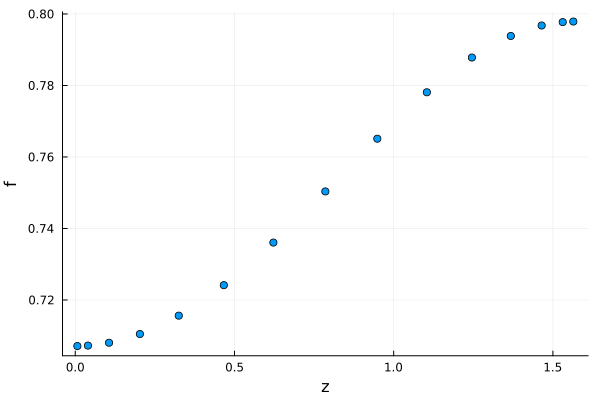

In [11]:
evaluations=Tuple{Float64,Float64}[]
function f!(z)
    val=integrandz(z,pi/2)
    push!(evaluations,(z,val))
    return val
end
@time quadgk(f!,0,pi/2)
scatter(evaluations;xlabel="z",ylabel="f",label="")

We can also look at the order in which the points are chosen:

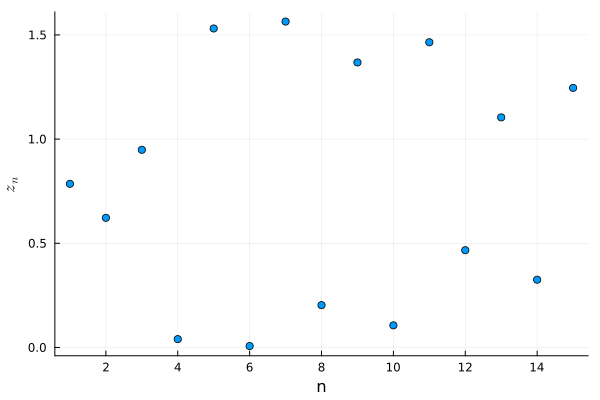

In [12]:
scatter([z for (z,f) in evaluations],xlabel="n",ylabel=L"z_n",label="")

Note:  without our transformation it needed many more points

In [13]:
quadgk_count(x->PeriodIntegrand(x,pi/2),0,1)

(1.1803405931478603, 1.537190156500909e-8, 1305)

  0.000119 seconds (1.31 k allocations: 91.266 KiB)


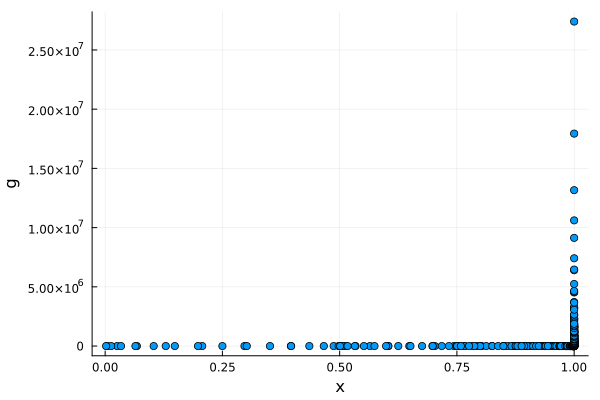

In [14]:
evaluations=Tuple{Float64,Float64}[]
function g!(x)
    val=PeriodIntegrand(x,pi/2)
    push!(evaluations,(x,val))
    return val
end
@time quadgk(g!,0,1)
scatter(evaluations;xlabel="x",ylabel="g",label="")

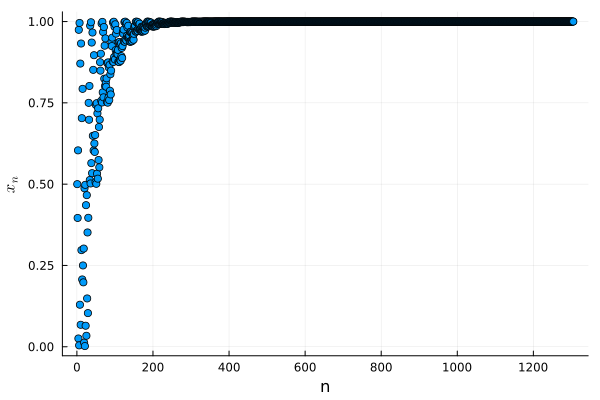

In [15]:
scatter([x for (x,f) in evaluations],xlabel="n",ylabel=L"x_n",label="")

### Gaussian Quadratures

How on Earth can the integration routine be so effective?  

There are two pieces of magic:
1. Gaussian Quadratures
2. Adaptive Quadratures

#### Magic behind Gaussian Quadratures

The idea is that if one evaluates the function at **non-equally spaced** points, one can accelerate convergence

For example, suppose we want to calculate $\int_{-1}^1 f(x) dx$ using only three function evaluations.  In trapezoid rule those evaluations would be at $x=-1,0,1$.  For midpoint rule they would be at $x=-2/3,0,2/3$.  In Simpson's rule the would be at $x=-1,0,1$, but we would weight them unequally.  The most general quadrature rule is
\begin{equation}
I\approx \sum_j w_j f(x_j).
\end{equation}
The most general 3-point symmetric quadrature rule would be 
\begin{equation}
I=a f(0) + b f(s)+ b f(-s)
\end{equation}
where $a,b,s$ are parameters.

We will choose these parameters so that we get the correct integral for various polynomials
\begin{align}
\int_{-1}^1 x^0 dx &\to a+2b &=2\\
\int_{-1}^1 x^1 dx &\to 0 &= 0\\
\int_{-1}^1 x^2 dx &\to 2b s^2 &= 2/3\\
\int_{-1}^1 x^3 dx &\to 0 &= 0\\
\int_{-1}^1 x^4 dx &\to 2b s^4 &= 2/5\\
\int_{-1}^1 x^5 dx &\to 0 &= 0\\
\end{align}
We can solve these to find $s=\sqrt{3/5}, a=8/9, b=5/9$.  With these 3 function evaluations we can exactly integrate any polynomial up to 5th order.

There is some beautiful mathematics behind deriving higher order Gaussian Quadrature methods, using the properties of orthogonal polynomials.  We will not get into it here, but they have led to efficient ways to calculate the nodes and weights for very [high orders](https://pi.math.cornell.edu/~ajt/papers/QuadratureEssay.pdf).

#### Adaptive Quadratures

The other trick that `quadgk` does is it uses *adaptive quadratures*.  This means it subdivides only the parts of the domain where the function is varying fastest.

We could code our own Adaptive Gaussian Quadrature routine, but there is not much need.  It makes more sense to just use the packaged version.  Numerical Recipies has a nice discussion of the algorithm if you want to play with it.

# Working with files and notebooks at the same time

At this point in the lecture, I'll illustrate how to shift to JupyterLab -- opening this notebook and the file [trapezoid.jl](https://github.com/em256/phys4480/blob/main/trapezoid.jl) at the same time

1. click the "Open in.." button in the upper right
2. click the "Simple" slider on the bottom left, to turn off simple mode
3. click the file browser icon on the left to open a file browser.
4. double click on the file "trapezoid.jl"
5. Drag the tab to show the text file side-by side with the notebook

You can now freely copy and paste betweeen the notebook and the file

In [16]:
include("trapezoid.jl")

nrtrap

In [17]:
nrtrap(x->x^2,(1,2))

2.3333333333721384

You can use create new text files, edit them, and then run them with `include`.  You can change the file and then `include` them again.  This is really useful if you are building tools that you will use in multiple projects.

At this point in the lecture I will demonstrate creating a new text file, adding some code to it, and including it. 

I will then illustrate opening a terminal, and running the script using Julia from the command line.

# Line Integrals

In [22]:
zero(1.5)

0.0

In [23]:
zero(1)

0

In [24]:
zero([1,2])

2-element Vector{Int64}:
 0
 0

In [25]:
using LinearAlgebra

Note:  I made one very small change in our trapezoid integrator when I put it in "trapezoid.jl".  When we compare the integral's value for different order, I changed the `abs` to `norm`.  For real (or complex) numbers this works the same, but norm can also work on vectors.

In [26]:
@show norm(-1)
@show norm(1)
@show norm(1+2im)
@show norm([2,3,1])^2

norm(-1) = 1.0
norm(1) = 1.0
norm(1 + 2im) = 2.23606797749979
norm([2, 3, 1]) ^ 2 = 14.0


14.0

We could then calculate something like 
$$
\int_{\vec{a}}^{\vec{b}} \vec{F}\cdot d{\vec r}
$$
along a straight line path

In [27]:
[1 2 3]*[1,1,1]

1-element Vector{Int64}:
 6

In [28]:
[1,2,3]

3-element Vector{Int64}:
 1
 2
 3

In [29]:
F(r)= -transpose(r)/norm(r)^3

F (generic function with 1 method)

In [30]:
@show F([1; 0; 0])
@show F([2; 0; 0])
@show F([0; 1; 0])
@show F([0; 2; 0]);

F([1; 0; 0]) = [-1.0 0.0 0.0]
F([2; 0; 0]) = [-0.25 0.0 0.0]
F([0; 1; 0]) = [0.0 -1.0 0.0]
F([0; 2; 0]) = [0.0 -0.25 0.0]


In [31]:
nrtrap(F,([1; 0; 0],[2; 0; 0]))

-0.5000000000084912

In [32]:
V(r)=1/norm(r)

V (generic function with 1 method)

In [33]:
V([2; 0; 0])-V([1; 0; 0])

-0.5

In [34]:
nrtrap(F,([1; 0; 0],[3; 4; 5]))

-0.858578643752598

In [35]:
V([3; 4; 5])-V([1; 0; 0])

-0.8585786437626906

## Contour Integrals

Similarly we can do straight-line integrals in the complex plane

In [36]:
nrtrap(z->1/z,(1,1+1im))

0.3465735902605708 + 0.7853981633877467im

In [37]:
quadgk(z->1/z,1,1+1im)

(0.3465735902799727 + 0.7853981633974483im, 6.712470243266902e-10)

Closed contours:

In [38]:
nodes=[1,1im,-1,-1im,1]
1/(2im*pi)*sum(nrtrap(z->1/z,(nodes[j],nodes[j+1])) for j in 1:(length(nodes)-1))

0.9999999999876426 + 1.8860385562280946e-17im

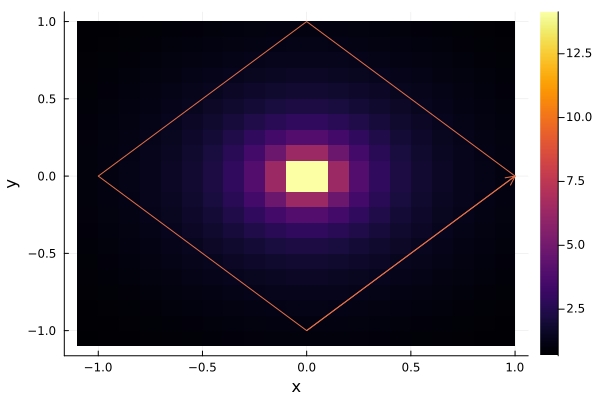

In [39]:
using Plots
xvals=[x for x in -1.05:0.1:1]
yvals=[y for y in -1.05:0.1:1]
zvals=[1/(x+y*im) for x in xvals, y in yvals]
heatmap(xvals,yvals,abs.(zvals))
plot!([(real(z),imag(z)) for z in nodes],
    label="",xlabel="x",ylabel="y",arrow=true)

The same command with quadgk.  The `...` notation is referred to as a `splat`.  It takes the elements of a list, and inserts them into the function

In [40]:
1/(2im*pi)*quadgk(z->1/z,nodes...)[1]

1.0 + 1.766974823035287e-17im

In [41]:
nodes

5-element Vector{Complex{Int64}}:
  1 + 0im
  0 + 1im
 -1 + 0im
  0 - 1im
  1 + 0im

In [42]:
1/(2im*pi)*quadgk(z->1/z,1,1im,-1,-1im,1)[1]

1.0 + 1.766974823035287e-17im

This takes the integral from $1$ to $i$ -- then to $-1$ -- then to $-i$ -- then to $1$ -- all with straight line paths between them.

# Higher dimensional integrals

Higher dimensional integrals are hard.  Grids are hopeless once you get beyond 2 or 3 dimensions.  Say you have a 10 dimensional integral, and you break each dimension into 10 points.  That would then requre $10^{10}$ function evaluations.

To do high dimensional integrals efficiently you often need to do some changes of variables, or breaking up the domain.  

A good starting point is the canned routine `hcubature`

In [43]:
using HCubature  

In [44]:
f(x,y) = x^2 + 5y^2
f(v) = f(v...)  # f accepts a vector
a0, b0 = 0, 1
a1, b1 = 0, 2
hcubature(f, (a0, a1), (b0, b1))

(14.0, 1.7763568394002505e-15)